In [1]:
# #!/usr/bin/env python3
# import re
# import pandas as pd
# import argparse
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.sparse import csr_matrix, hstack
# from scipy import sparse

# class MetadataFilter:
#     def __init__(self, metadata_tsv):
#         self.metadata_df = pd.read_csv(metadata_tsv, delimiter='\t', dtype=str, engine="c")
#         self.filtered_metadata_df = self.metadata_df.copy()
    
#     def filter_by_accessions(self, accessions):
#         self.filtered_metadata_df = self.metadata_df[self.metadata_df['acc'].isin(accessions)]
    
#     def filter_by_search_terms(self, search_terms, columns_to_search=None):
#         search_columns = columns_to_search if columns_to_search else self.metadata_df.columns.tolist()
        
#         mask = pd.Series(False, index=self.metadata_df.index)
#         for col in search_columns:
#             for term in search_terms:
#                 mask |= self.metadata_df[col].str.contains(term, case=False, na=False)
        
#         self.filtered_metadata_df = self.metadata_df[mask]
    
#     def get_filtered_accessions(self):
#         return self.filtered_metadata_df['acc'].unique().tolist()

# class SandpiperData:
#     def __init__(self, sandpiper_tsv):
#         # Load the data and create the sparse matrices
#         self.samples, self.taxa = self._build_indices(sandpiper_tsv)
#         self.presence_matrix, self.coverage_matrix = self._create_sparse_matrices(sandpiper_tsv)
        
#         # Dictionary to store filter indices
#         self.filters = {
#             'unfiltered_samples': np.arange(len(self.samples)),
#             'filtered_by_accessions': np.arange(len(self.samples)),
#             'filtered_by_taxa_count': np.arange(len(self.samples)),
#             'combined_filter': np.arange(len(self.samples)),  
#             'filtered_taxa': np.arange(len(self.taxa))
            
#         }
        
#     def _build_indices(self, sandpiper_tsv):
#         # Build sample and taxon indices
#         chunk_iterator = pd.read_csv(sandpiper_tsv, delimiter='\t', dtype=str, usecols=['sample', 'taxonomy'], chunksize=100000, engine="c")
        
#         sample_to_index = {}
#         taxon_to_index = {}
        
#         for chunk in chunk_iterator:
#             for sample in chunk['sample'].unique():
#                 if sample not in sample_to_index:
#                     sample_to_index[sample] = len(sample_to_index)
#             for taxon in chunk['taxonomy'].unique():
#                 if taxon not in taxon_to_index:
#                     taxon_to_index[taxon] = len(taxon_to_index)
        
#         # Convert index mappings to lists
#         samples = [None] * len(sample_to_index)
#         for sample, idx in sample_to_index.items():
#             samples[idx] = sample
        
#         taxa = [None] * len(taxon_to_index)
#         for taxon, idx in taxon_to_index.items():
#             taxa[idx] = taxon
        
#         # Store mappings for later use
#         self.sample_to_index = sample_to_index
#         self.taxon_to_index = taxon_to_index
        
#         return samples, taxa
    
#     def _create_sparse_matrices(self, sandpiper_tsv):
#         # Initialize lists for sparse matrix construction
#         data_presence = []
#         data_coverage = []
#         row_indices = []
#         col_indices = []
        
#         chunk_iterator = pd.read_csv(sandpiper_tsv, delimiter='\t', dtype=str, chunksize=100000, engine="c")
        
#         for chunk in chunk_iterator:
#             # Map samples and taxa to indices
#             sample_indices = chunk['sample'].map(self.sample_to_index)
#             taxon_indices = chunk['taxonomy'].map(self.taxon_to_index)
            
#             # Convert coverage to numeric
#             coverage_values = pd.to_numeric(chunk['coverage'], errors='coerce').fillna(0)
            
#             # Append data
#             data_presence.extend([1] * len(chunk))
#             data_coverage.extend(coverage_values)
#             row_indices.extend(sample_indices)
#             col_indices.extend(taxon_indices)
        
#         num_samples = len(self.samples)
#         num_taxa = len(self.taxa)
        
#         # Create presence/absence sparse matrix
#         presence_matrix = csr_matrix((data_presence, (row_indices, col_indices)), shape=(num_samples, num_taxa), dtype=int)
        
#         # Create coverage sparse matrix
#         coverage_matrix = csr_matrix((data_coverage, (row_indices, col_indices)), shape=(num_samples, num_taxa), dtype=float)
        
#         return presence_matrix, coverage_matrix
    
#     def filter_samples_by_taxa_string(self, taxa_list, filter_type='unfiltered_samples', combine=False):
#         """
#         Filters samples based on the presence of taxa strings provided in `taxa_list`.
        
#         Parameters:
#         - taxa_list: List of taxa strings to search for in the taxa names.
#         - filter_type: Specifies the filter type to apply before filtering by taxa string.
#         """
#         # Step 1: Identify indices of taxa that match any of the strings in taxa_list
#         organism_indices = [
#             idx for idx, taxon in enumerate(self.get_filtered_taxa())
#             if any(org in taxon for org in taxa_list)
#         ]
        
#         # Step 2: Check presence of these taxa in each sample and filter samples accordingly
#         presence_matrix = self.get_presence_matrix(filter_type=filter_type)
#         organism_presence = presence_matrix[:, organism_indices].sum(axis=1).A.flatten() > 0
#         filtered_sample_indices = [i for i, present in enumerate(organism_presence) if present]
    
#         # Step 3: Update filters with the new sample indices
#         self.filters['filtered_by_accessions'] = np.array(filtered_sample_indices)
        
#         if combine:
#             # Compute the combined filter as the intersection of filtered_by_accessions and filtered_by_taxa_count
#             filtered_sample_set = set(self.filters['filtered_by_accessions'])
#             valid_sample_set = set(self.filters['filtered_by_taxa_count'])
#             self.filters['combined_filter'] = np.array(list(filtered_sample_set.intersection(valid_sample_set)))
        
#     def filter_by_accessions(self, accessions, combine=False):
#         # Map accessions to indices
#         accession_to_index = self.sample_to_index
#         self.filters['filtered_by_accessions'] = np.array([accession_to_index[acc] for acc in accessions if acc in accession_to_index])

#         if combine:
#             # Compute the combined filter as the intersection of filtered_by_accessions and filtered_by_taxa_count
#             filtered_sample_set = set(self.filters['filtered_by_accessions'])
#             valid_sample_set = set(self.filters['filtered_by_taxa_count'])
#             self.filters['combined_filter'] = np.array(list(filtered_sample_set.intersection(valid_sample_set)))
        
#     def filter_taxa_by_sample_count(self, filter_type='unfiltered_samples', min_count_samples=0):
#         # Apply taxa threshold if min_sample_count > 0
#         if min_count_samples > 0:
#             presence_matrix = self.presence_matrix[self.filters[filter_type], :]
#             taxa_counts = np.array((presence_matrix > 0).sum(axis=0)).flatten()
#             valid_taxa_indices = np.where(taxa_counts >= min_count_samples)[0]
#             self.filters['filtered_taxa'] = valid_taxa_indices
#         else:
#             self.filters['filtered_taxa'] = np.arange(len(self.taxa))
    
#     def filter_taxa_level(self, level="s__", filter_type='unfiltered_samples', combine=False):

#         # Determine which taxa to use based on the combine flag
#         if combine: 
#             filtered_taxa = self.get_filtered_taxa()
#         else:
#             filtered_taxa = self.taxa
        
#         # Get indices of taxa containing the specified level
#         valid_taxa_indices = np.array([
#             idx for idx, taxon in enumerate(self.taxa)
#             if level in taxon and (not combine or taxon in filtered_taxa)
#         ])
        
#         # Set 'filtered_taxa' filter to be the indices of valid taxa
#         self.filters['filtered_taxa'] = valid_taxa_indices
        
#     def filter_sample_by_taxa_count(self, min_count_taxa=0, combine=False):
#         # Filter samples by taxa count
#         presence_matrix = self.get_presence_matrix(filter_type='unfiltered_samples')
#         sample_taxa_counts = np.array(presence_matrix.sum(axis=1)).flatten()
#         valid_sample_indices = np.where(sample_taxa_counts >= min_count_taxa)[0]
#         self.filters['filtered_by_taxa_count'] = valid_sample_indices
        
#         if combine:
#             # Compute the combined filter as the intersection of filtered_by_accessions and filtered_by_taxa_count
#             filtered_sample_set = set(self.filters['filtered_by_accessions'])
#             valid_sample_set = set(self.filters['filtered_by_taxa_count'])
#             self.filters['combined_filter'] = np.array(list(filtered_sample_set.intersection(valid_sample_set)))
        
#     def get_presence_matrix(self, filter_type='combined_filter'):
#         sample_indices = self.filters[filter_type]
#         return self.presence_matrix[sample_indices, :][:, self.filters['filtered_taxa']]
        
#     def get_filtered_coverage_matrix(self, filter_type='combined_filter'):
#         sample_indices = self.filters[filter_type]
#         return self.coverage_matrix[sample_indices, :][:, self.filters['filtered_taxa']]
    
#     def get_filtered_samples(self, filter_type='combined_filter'):
#         indices = self.filters[filter_type]
#         return [self.samples[i] for i in indices]
    
#     def get_filtered_taxa(self):
#         # Return the list of filtered taxa
#         return [self.taxa[i] for i in self.filters['filtered_taxa']]
    
#     def get_filtered_sandpiper_df(self, filter_type='combined_filter'):
#         sample_indices = self.filters[filter_type]
#         presence_matrix_filtered = self.get_presence_matrix(filter_type)
#         coo = presence_matrix_filtered.tocoo()
#         data = {
#             'sample': [self.samples[sample_indices[i]] for i in coo.row],
#             'taxonomy': [self.taxa[self.filters['filtered_taxa'][j]] for j in coo.col],
#             'presence': coo.data
#         }
#         filtered_df = pd.DataFrame(data)
#         return filtered_df
        
#     def add_taxa_levels_to_presence_matrix(self, pattern="g__"):
#         """
#         Adds additional taxa for levels matching the specified pattern in the taxa strings.
#         Updates the presence matrix to include higher taxonomic levels.
        
#         Parameters:
#         - pattern: Regex pattern to identify specific levels (e.g., "g__" for genus level).
#         """
        
#         # Define the columns for taxonomic levels
#         level_names = ["Root", "d__", "p__", "c__", "o__", "f__", "g__", "s__"]
        
#         # Split taxonomic strings into a DataFrame with each level as a separate column
#         taxa_series = pd.Series(self.taxa)
#         taxa_df = taxa_series.str.split("; ", expand=True)
#         taxa_df.columns = level_names[:taxa_df.shape[1]]  # Limit columns to the existing levels
        
#         # Identify the target level based on the pattern
#         target_level = next((level for level in level_names if re.fullmatch(pattern, level)), None)
#         if not target_level or target_level not in taxa_df.columns:
#             print(f"No matching level found for pattern: {pattern}")
#             return
        
#         # Get the higher-level taxa for each taxon
#         higher_level_taxa = taxa_df[target_level]
        
#         # Identify unique higher-level taxa
#         unique_levels = higher_level_taxa.dropna().unique()
        
#         # Map higher-level taxa to indices
#         level_to_index = {level: idx for idx, level in enumerate(unique_levels)}
        
#         # Create the mapping matrix T (num_taxa x num_unique_levels)
#         # For each taxon, set T[taxon_idx, higher_level_idx] = 1
#         num_taxa = len(self.taxa)
#         num_unique_levels = len(unique_levels)
#         row_indices = []
#         col_indices = []
#         data = []
        
#         for taxon_idx, level in enumerate(higher_level_taxa):
#             if pd.isnull(level):
#                 continue  # Skip if level is NaN
#             level_idx = level_to_index[level]
#             row_indices.append(taxon_idx)
#             col_indices.append(level_idx)
#             data.append(1)
        
#         T = csr_matrix((data, (row_indices, col_indices)), shape=(num_taxa, num_unique_levels), dtype=int)
        
#         # Compute the new presence matrix L (num_samples x num_unique_levels)
#         P = self.presence_matrix  # Original presence matrix (num_samples x num_taxa)
#         L = P @ T  # Matrix multiplication
        
#         # Binarize L (set all positive entries to 1)
#         L.data = np.ones_like(L.data)
        
#         # Extend self.taxa with new higher-level taxa
#         self.taxa.extend(unique_levels)
        
#         # Extend the presence matrix by concatenating L to P
#         self.presence_matrix = hstack([P, L], format='csr')
#         self.filters['filtered_taxa'] = np.arange(len(self.taxa))

# class RatioAnalyzer:
#     def __init__(self, sandpiper_data, total_counts_filter='unfiltered_samples'):
#         self.sandpiper_data = sandpiper_data
#         self.ratios_df = None
#         self.total_counts = self.calculate_counts(filter_type=total_counts_filter) # Store total counts to avoid recomputation
        
#     def calculate_counts(self, filter_type='unfiltered_samples'):
#         # Calculate counts per taxon in the filtered dataset (filtered samples and filtered taxa)
#         presence_matrix = self.sandpiper_data.get_presence_matrix(filter_type=filter_type)
#         counts = np.array(presence_matrix.sum(axis=0)).flatten()
#         return counts
        
#     def compute_taxon_ratios(self, filter_type='filtered_by_accessions'):
        
#         # Step 1: Calculate filtered counts
#         filtered_counts = self.calculate_counts(filter_type=filter_type)

#         # Step 2: Compute ratios
#         with np.errstate(divide='ignore', invalid='ignore'):
#             ratios = np.true_divide(filtered_counts, self.total_counts)
#             ratios[~np.isfinite(ratios)] = 0  # Replace NaN and inf with 0
        
#         # Step 3: Get the list of filtered taxa
#         filtered_taxa = self.sandpiper_data.get_filtered_taxa()
        
#         # Step 4: Create DataFrame with the computed ratios
#         self.ratios_df = pd.DataFrame({
#             'taxon': filtered_taxa,
#             'filtered_counts': filtered_counts,
#             'all_counts': self.total_counts,
#             'ratio': ratios
#         })
        
#     def plot_ratios(self, output_plot_file=None, threshold=None):
#         # Sort the dataframe by ratio in descending order
#         ratios_df_sorted = self.ratios_df.sort_values(by='ratio', ascending=False).reset_index(drop=True)
        
#         # Create the plot
#         fig, ax = plt.subplots(figsize=(10, 6))
#         ax.plot(ratios_df_sorted['ratio'].values, marker='o', markersize=5)
#         ax.set_xlabel('Taxa (ordered by ratio)')
#         ax.set_ylabel('Ratio')
#         ax.set_title('Taxon Ratios')
#         ax.set_ylim(-0.05, 1.05)
#         ax.grid(True)
        
#         # Mark the threshold if provided
#         if threshold is not None:
#             # Find the index where the ratio falls below the threshold
#             threshold_indices = ratios_df_sorted[ratios_df_sorted['ratio'] >= threshold].index
#             if len(threshold_indices) > 0:
#                 cutoff_index = threshold_indices[-1]
#                 ax.axvline(x=cutoff_index, color='red', linestyle='--', label=f'Threshold = {threshold}')
#                 ax.legend()
#             else:
#                 print(f"No taxa found with ratio >= {threshold}")
        
#         # Save or show the plot
#         fig.tight_layout()
#         if output_plot_file:
#             fig.savefig(output_plot_file)
#             plt.close(fig)
#         else:
#             plt.show()
        
#     def filter_ratios(self, ratio_threshold, counts_threshold): #, taxa_to_exclude=None):
#         # Filter the ratios based on the threshold
#         filtered_ratios_df = self.ratios_df[self.ratios_df['ratio'] >= ratio_threshold]
#         filtered_ratios_df = filtered_ratios_df[filtered_ratios_df['all_counts'] >= counts_threshold]
#         return filtered_ratios_df

# class CorrelationAnalyzer:
#     def __init__(self, coverage_matrix, samples, taxa):
#         self.coverage_matrix = coverage_matrix  # Sparse matrix
#         self.samples = samples
#         self.taxa = taxa
#         self.normalized_matrix = None
#         self.cooccurrence_matrix = None
    
#     def normalize_coverage_matrix(self):
#         # Normalize the coverage matrix by row (sample)
#         row_sums = self.coverage_matrix.sum(axis=1).A1  # Convert to 1D array
        
#         # Avoid division by zero
#         row_sums[row_sums == 0] = 1
#         normalized_data = self.coverage_matrix.multiply(1 / row_sums[:, np.newaxis])
#         self.normalized_matrix = normalized_data
    
#     def compute_pairwise_cooccurrence(self, prefixes, n_nonzero_cols=10, threshold=0.6):
#         # Convert normalized_matrix to DataFrame for compatibility
#         df = pd.DataFrame.sparse.from_spmatrix(
#             self.normalized_matrix, index=self.samples, columns=self.taxa)
        
#         # Identify columns containing the specified prefixes
#         prefix_columns = [col for col in df.columns if any(prefix in col for prefix in prefixes)]
#         if not prefix_columns:
#             print(f"No columns found containing any of the prefixes '{', '.join(prefixes)}'.")
#             return
        
#         # Filter columns with more than n_nonzero_cols non-zero values
#         valid_columns = df.columns[(df > 0).sum() > n_nonzero_cols]
        
#         # Compute pairwise correlations only for prefix columns against all valid columns
#         results = {}
#         for col in prefix_columns:
#             correlations = df[valid_columns].corrwith(df[col], method='spearman')
#             results[col] = correlations
        
#         if not results:
#             print(f"No correlations found for columns containing any of the prefixes '{', '.join(prefixes)}'.")
#             return
        
#         cooccurrence_matrix = pd.DataFrame(results).fillna(0).T
        
#         # Filter out columns where none of the correlation coefficients are above the threshold
#         self.cooccurrence_matrix = cooccurrence_matrix.loc[:, (cooccurrence_matrix.abs() > threshold).any(axis=0)]

In [1]:
from metacooccur import *
import copy

# Initialise variables
Need to load once, then different filterings made from it when required

In [4]:
ls ../


cli.py       filter.py    plot.py        ratios.py           utensils.py*
data/        format.py    prelim_files/  search.py
download.py  __init__.py  __pycache__/   setup_database.py*


In [5]:
metadata_filter = MetadataFilter("../data/sra_metadata_parsed_intersection_reduced.tsv")
sandpiper_data = SandpiperData("../data/sandpiper0.3.0.condensed_intersection.csv")

In [15]:
import pickle
with open('ingredients.pkl', 'wb') as file:
    pickle.dump(ingredients, file)


In [13]:
ingredients = Ingredients()
ingredients.presence_matrix = sandpiper_data.presence_matrix
ingredients.coverage_matrix = sandpiper_data.coverage_matrix
ingredients.samples = sandpiper_data.samples
ingredients.taxa = sandpiper_data.taxa


hello


In [12]:
class Ingredients:
    def __init__(self):
        print("hello")

## 1. Soil metagenomes - identify any possible taxons "only" found in metagenomes identified as soil

##### Filter metadata and sandpiper 
At this point, no filter on the contents of the datasets is included e.g. no datasets are excluded if they only contain 3 unique taxa etc. 

In [4]:
# search for all sra accessions with soil in the organism column e.g. soil metagenome
metadata_filter.filter_by_search_terms(["soil"], ["organism"])
filtered_accessions = metadata_filter.get_filtered_accessions()

# set the filtered_by_accessions filter for the sandpiper data object
sandpiper_data.filter_by_accessions(filtered_accessions)

# view the filteredsandpiper data file
filtered_sandpiper = sandpiper_data.get_filtered_sandpiper_df(filter_type='filtered_by_accessions')
filtered_sandpiper

,sample,taxonomy,presence
0,SRR4254071,Root; d__Archaea,1
1,SRR4254071,Root; d__Bacteria,1
2,SRR4254071,Root; d__Bacteria; p__Pseudomonadota,1
3,SRR4254071,Root; d__Bacteria; p__Actinomycetota,1
4,SRR4254071,Root; d__Bacteria; p__Bacillota; c__Bacilli,1
...,...,...,...
5539507,SRR13298160,Root; d__Bacteria; p__Bacillota_A; c__Clostrid...,1
5539508,SRR13298160,Root; d__Bacteria; p__Bacillota_A; c__Thermose...,1
5539509,SRR13298160,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,1
5539510,SRR13298160,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,1


##### Determine ratios, plot the distribution of ratios including the threshold, where all taxa with a lower ratio than that are later filtered out for investigation

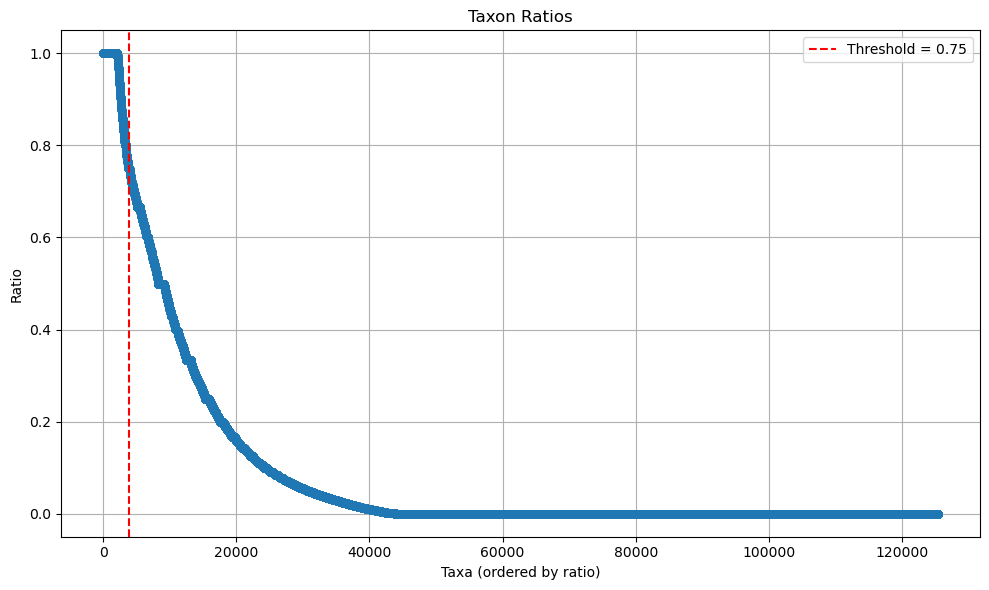

In [5]:
# initiliase a ratio analyzer object with the sandpiper data.
# when initialised, it calculates the total counts across all accessions i.e. the unfiltered counts
ratio_analyzer = RatioAnalyzer(sandpiper_data)

# compute taxon ratios by default uses the filtered_by_accessions filter to calculate the ratio of filtered vs total
ratio_analyzer.compute_taxon_ratios()
ratio_analyzer.plot_ratios(threshold=0.75)

In [6]:
# filter the results, counts_threshold can either be set here on specifically on the sandpiper_data set (see next spot)
filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.75, counts_threshold=0)
filtered_ratios

,taxon,filtered_counts,all_counts,ratio
1555,Root; d__Bacteria; p__Actinomycetota; c__Acidi...,1043,1375,0.758545
1577,Root; d__Bacteria; p__Actinomycetota; c__UBA47...,815,1058,0.770321
1742,Root; d__Bacteria; p__Acidobacteriota; c__Blas...,1153,1470,0.784354
1750,Root; d__Bacteria; p__Acidobacteriota; c__Ther...,639,785,0.814013
1775,Root; d__Bacteria; p__Nitrospirota; c__Nitrosp...,616,785,0.784713
...,...,...,...,...
125414,Root; d__Bacteria; p__Pseudomonadota; c__Gamma...,1,1,1.000000
125415,Root; d__Bacteria; p__Patescibacteria; c__Sacc...,6,6,1.000000
125417,Root; d__Bacteria; p__Pseudomonadota; c__Gamma...,3,3,1.000000
125420,Root; d__Bacteria; p__Actinomycetota; c__Actin...,1,1,1.000000


##### Determine ratios again, but this time ensure that taxa was detected in at least 5 metagenomes

Set this on the sandpiper data object itself (useful for integration with other modules)

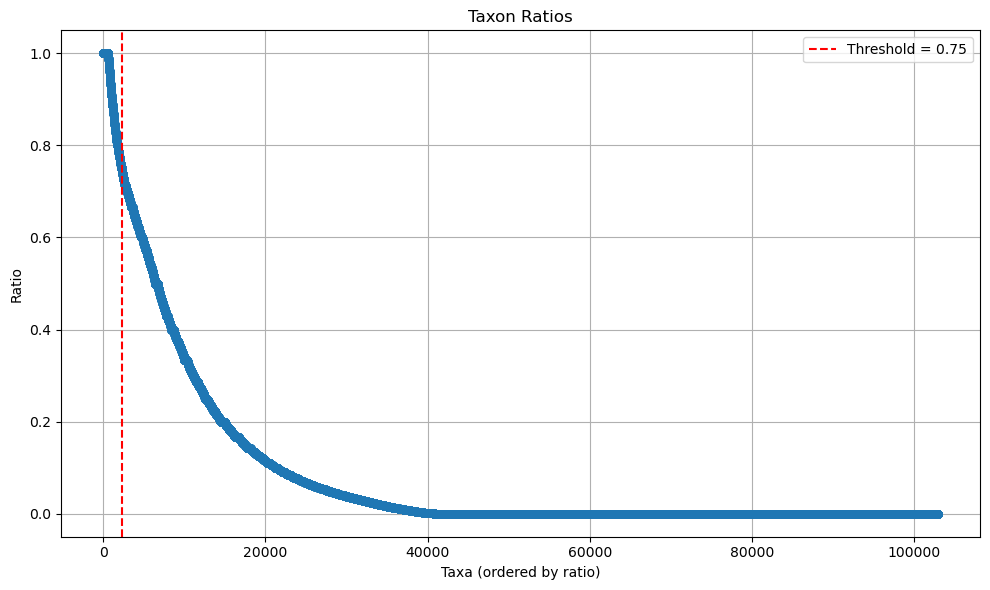

In [7]:
sandpiper_data.filter_taxa_by_sample_count(min_count_samples=5)

# doesn't affect the calculated ratios but does affect those plotted/reported (see the index on x axis)
ratio_analyzer = RatioAnalyzer(sandpiper_data)
ratio_analyzer.compute_taxon_ratios()
ratio_analyzer.plot_ratios(threshold=0.75)

In [8]:
filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.75, counts_threshold=0)
filtered_ratios

,taxon,filtered_counts,all_counts,ratio
1555,Root; d__Bacteria; p__Actinomycetota; c__Acidi...,1043,1375,0.758545
1577,Root; d__Bacteria; p__Actinomycetota; c__UBA47...,815,1058,0.770321
1742,Root; d__Bacteria; p__Acidobacteriota; c__Blas...,1153,1470,0.784354
1750,Root; d__Bacteria; p__Acidobacteriota; c__Ther...,639,785,0.814013
1775,Root; d__Bacteria; p__Nitrospirota; c__Nitrosp...,616,785,0.784713
...,...,...,...,...
102772,Root; d__Bacteria; p__Actinomycetota; c__Actin...,6,6,1.000000
102799,Root; d__Archaea; p__Thermoplasmatota; c__Ther...,5,6,0.833333
102806,Root; d__Bacteria; p__Actinomycetota; c__Actin...,8,8,1.000000
102915,Root; d__Bacteria; p__Verrucomicrobiota; c__Ve...,7,7,1.000000


##### Determine ratios again, but add a requirement for each sample (metagenome) to contain more than 10 taxa (includes all levels e.g. up to root (bacteria, archaea))


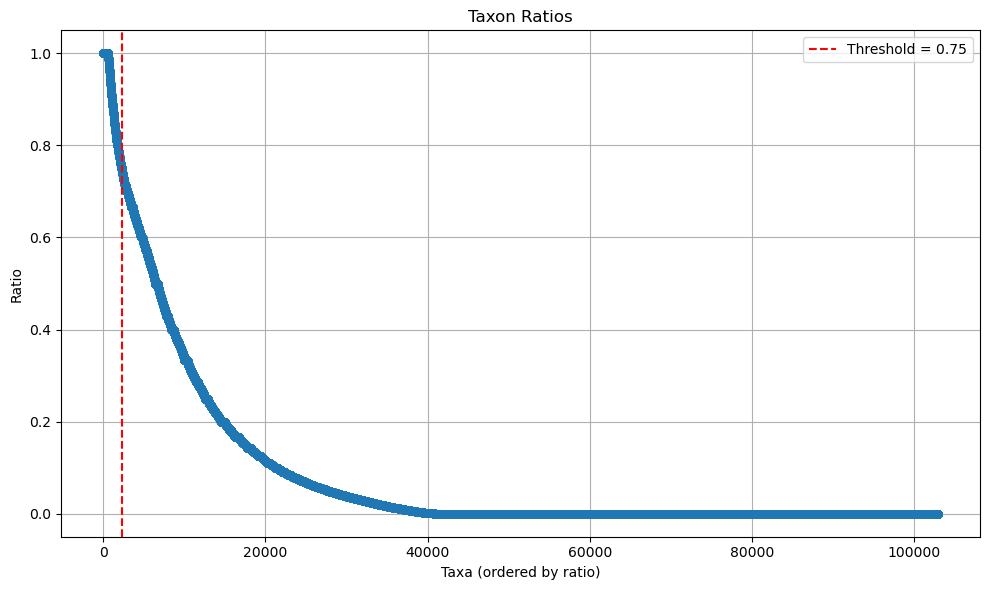

In [9]:
# this function creates a new filter flag ('filtered_by_taxa_count'), which we want to compare to use to filter all total counts
# Additioanlly, the combine flag combines this filter with the earlier filtered_by_accession filter, 
# this combined flag is used as the filter_type flag for determining ratios
sandpiper_data.filter_sample_by_taxa_count(min_count_taxa=10, combine=True)

ratio_analyzer = RatioAnalyzer(sandpiper_data, total_counts_filter='filtered_by_taxa_count')
ratio_analyzer.compute_taxon_ratios(filter_type='combined_filter')
ratio_analyzer.plot_ratios(threshold=0.75)

In [10]:
filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.75, counts_threshold=0)
filtered_ratios

,taxon,filtered_counts,all_counts,ratio
1555,Root; d__Bacteria; p__Actinomycetota; c__Acidi...,1043,1375,0.758545
1577,Root; d__Bacteria; p__Actinomycetota; c__UBA47...,815,1058,0.770321
1742,Root; d__Bacteria; p__Acidobacteriota; c__Blas...,1153,1470,0.784354
1750,Root; d__Bacteria; p__Acidobacteriota; c__Ther...,639,785,0.814013
1775,Root; d__Bacteria; p__Nitrospirota; c__Nitrosp...,616,785,0.784713
...,...,...,...,...
102772,Root; d__Bacteria; p__Actinomycetota; c__Actin...,6,6,1.000000
102799,Root; d__Archaea; p__Thermoplasmatota; c__Ther...,5,6,0.833333
102806,Root; d__Bacteria; p__Actinomycetota; c__Actin...,8,8,1.000000
102915,Root; d__Bacteria; p__Verrucomicrobiota; c__Ve...,7,7,1.000000


## 2. Metagenomes containing the family Nitrospiraceae - identify any possible taxons that are associated with the family

##### Filter metadata and sandpiper

In [7]:
# taxa_list = ["f__Nitrospiraceae"]
taxa_list = ["s__Phosphoribacter baldrii"]

sandpiper_data.filter_samples_by_taxa_string(taxa_list=taxa_list)
# this changes the filtered_by_accessions filter but not the by_taxa_count filter

filtered_sandpiper = sandpiper_data.get_filtered_sandpiper_df(filter_type='filtered_by_accessions')
filtered_sandpiper

,sample,taxonomy,presence
0,SRR867165,Root; d__Bacteria,1
1,SRR867165,Root; d__Bacteria; p__Pseudomonadota,1
2,SRR867165,Root; d__Bacteria; p__Actinomycetota,1
3,SRR867165,Root; d__Bacteria; p__Actinomycetota; c__Actin...,1
4,SRR867165,Root; d__Bacteria; p__Pseudomonadota; c__Gamma...,1
...,...,...,...
657754,SRR999554,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,1
657755,SRR999554,Root; d__Bacteria; p__Actinomycetota; c__Actin...,1
657756,SRR999554,Root; d__Bacteria; p__Bdellovibrionota; c__Oli...,1
657757,SRR999554,Root; d__Bacteria; p__Pseudomonadota; c__Gamma...,1


##### Determine ratios and then threshold it for investigation

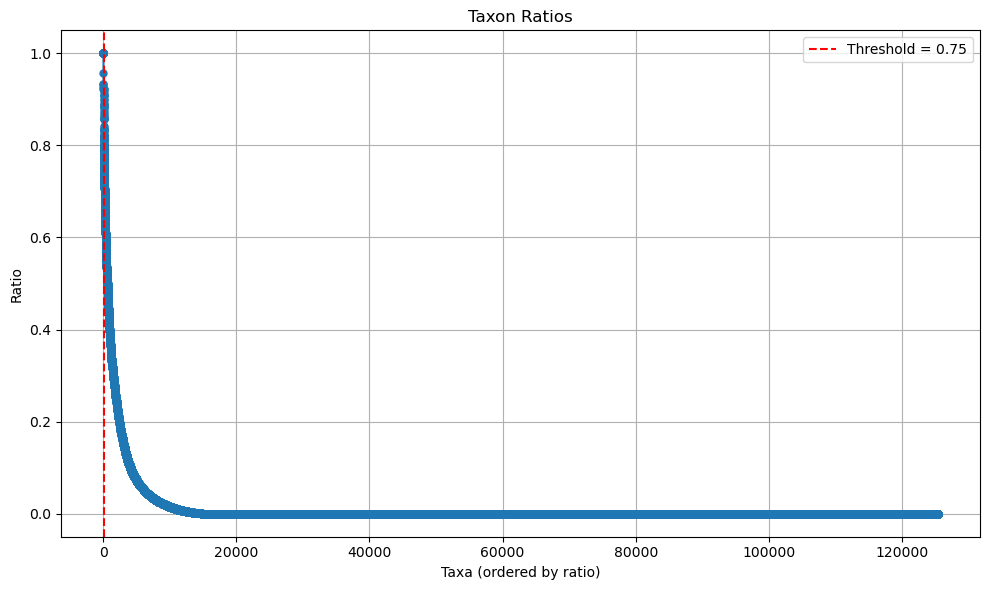

,taxon,filtered_counts,all_counts,ratio
4508,Root; d__Bacteria; p__Actinomycetota; c__Actin...,482,616,0.782468
8830,Root; d__Bacteria; p__Actinomycetota; c__Actin...,718,718,1.000000
9945,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,149,174,0.856322
9967,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,51,65,0.784615
9984,Root; d__Bacteria; p__Chloroflexota; c__Anaero...,57,74,0.770270
...,...,...,...,...
119742,Root; d__Bacteria; p__JAGOBX01; c__JAGOBX01; o...,6,7,0.857143
121175,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,2,2,1.000000
121176,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,3,3,1.000000
121177,Root; d__Bacteria; p__Armatimonadota; c__Fimbr...,2,2,1.000000


In [8]:
ratio_analyzer = RatioAnalyzer(sandpiper_data)

# by default uses the filtered_by_accessions and therefore don't need to reset the 
# combined_filter of the sandpiper_data just yet
ratio_analyzer.compute_taxon_ratios()
ratio_analyzer.plot_ratios(threshold=0.75)
filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.75, counts_threshold=0)
filtered_ratios

In [14]:
pd.set_option('max_colwidth',400)
test = filtered_ratios.sort_values(by="ratio")
(test[test["all_counts"] > 5]).sort_values(by="all_counts").iloc[-20:,:]

,taxon,filtered_counts,all_counts,ratio
42769,Root; d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__OLB9; s__OLB9 sp016715245,87,100,0.870000
42789,Root; d__Bacteria; p__Acidobacteriota; c__Blastocatellia; o__Pyrinomonadales; f__Pyrinomonadaceae; g__OLB17; s__OLB17 sp016703965,81,100,0.810000
42625,Root; d__Bacteria; p__Pseudomonadota; c__Gammaproteobacteria; o__Burkholderiales; f__Rhodocyclaceae; g__Uliginosibacterium; s__Uliginosibacterium sp016718265,90,108,0.833333
71935,Root; d__Bacteria; p__Actinomycetota; c__Actinomycetes; o__Actinomycetales; f__Dermatophilaceae; g__Tetrasphaera_A; s__Tetrasphaera_A sp016702415,108,117,0.923077
85827,Root; d__Bacteria; p__Pseudomonadota; c__Gammaproteobacteria; o__Burkholderiales; f__SG8-39; g__SZAS-79; s__SZAS-79 sp016713125,88,117,0.752137
82695,Root; d__Bacteria; p__Pseudomonadota; c__Gammaproteobacteria; o__Burkholderiales; f__Rhodocyclaceae; g__Accumulibacter; s__Accumulibacter affinis,104,133,0.781955
44012,Root; d__Bacteria; p__Pseudomonadota; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__JAAKGP01; s__JAAKGP01 sp016704435,102,133,0.766917
82696,Root; d__Bacteria; p__Pseudomonadota; c__Gammaproteobacteria; o__Competibacterales; f__Competibacteraceae; g__Competibacter_A; s__Competibacter_A sp016713505,111,135,0.822222
43376,Root; d__Bacteria; p__Actinomycetota; c__Thermoleophilia; o__Miltoncostaeales; f__Miltoncostaeaceae; g__CALMEC01; s__CALMEC01 sp937871165,124,144,0.861111
44024,Root; d__Bacteria; p__Chloroflexota; c__Anaerolineae; o__SSC4; f__SSC4; g__JADJYJ01; s__JADJYJ01 sp016719785,121,146,0.828767


In [13]:
sandpiper_data.filter_samples_by_taxa_string(taxa_list=["s__Nitrospira_D sp015904075"])
filtered_sandpiper = sandpiper_data.get_filtered_sandpiper_df(filter_type='filtered_by_accessions')
filtered_sandpiper

,sample,taxonomy,presence
0,SRR9924809,Root; d__Archaea,1
1,SRR9924809,Root; d__Bacteria,1
2,SRR9924809,Root; d__Bacteria; p__Actinomycetota,1
3,SRR9924809,Root; d__Bacteria; p__Bacillota; c__Bacilli,1
4,SRR9924809,Root; d__Bacteria; p__Bacillota_A; c__Clostridia,1
...,...,...,...
10319,SRR9924787,Root; d__Bacteria; p__Pseudomonadota; c__Alpha...,1
10320,SRR9924787,Root; d__Bacteria; p__Nitrospirota; c__Nitrosp...,1
10321,SRR9924787,Root; d__Bacteria; p__Pseudomonadota; c__Gamma...,1
10322,SRR9924787,Root; d__Bacteria; p__Nitrospirota; c__Nitrosp...,1


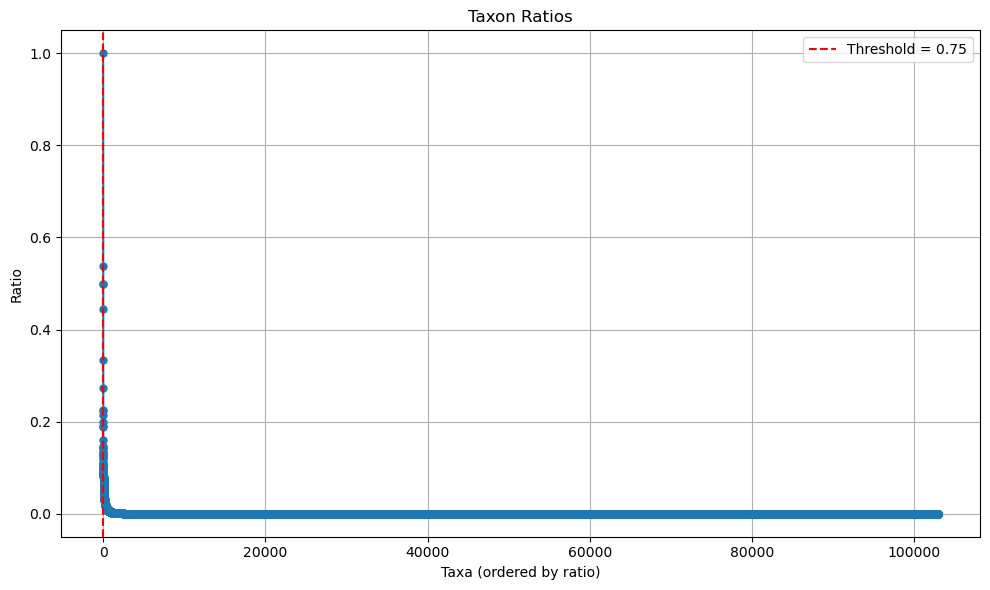

,taxon,filtered_counts,all_counts,ratio
55324,Root; d__Bacteria; p__Myxococcota; c__UBA9042;...,3,6,0.500000
93048,Root; d__Bacteria; p__Pseudomonadota; c__Gamma...,4,9,0.444444
95737,Root; d__Bacteria; p__Pseudomonadota; c__Alpha...,3,6,0.500000
98551,Root; d__Bacteria; p__Nitrospirota; c__Nitrosp...,7,13,0.538462
102938,Root; d__Bacteria; p__Nitrospirota; c__Nitrosp...,9,9,1.000000


In [14]:
ratio_analyzer = RatioAnalyzer(sandpiper_data)
ratio_analyzer.compute_taxon_ratios()
ratio_analyzer.plot_ratios(threshold=0.75)
filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.4, counts_threshold=0)
filtered_ratios

# iterative comparison of all species
now going to iteratively look at all species, present in more than 10 samples

In [15]:
# %%time

# ## also interested in looking at association with other levels above species
# sandpiper_data.add_taxa_levels_to_presence_matrix(pattern="g__")

In [16]:
# %%time

# sandpiper_data.filter_taxa_by_sample_count(min_count_samples=10)
# print(len([taxon for taxon in sandpiper_data.get_filtered_taxa() if "s__" in taxon]))


# print(len([taxon for taxon in sd.get_filtered_taxa() if "s__" in taxon]))

# sandpiper_data.filter_taxa_by_sample_count(min_count_samples=10) 
# print(len([taxon for taxon in sandpiper_data.get_filtered_taxa() if "s__" in taxon]))

# sd.filter_taxa_by_sample_count(min_count_samples=10) 
# print(len([taxon for taxon in sd.get_filtered_taxa() if "s__" in taxon]))

# print(len([taxon for taxon in sd.get_filtered_taxa() if "s__" in taxon]))

In [17]:
# %%time

# import copy
# sd = copy.deepcopy(sandpiper_data)

# sd.add_taxa_levels_to_presence_matrix(pattern="g__")

# sd.filter_taxa_by_sample_count(min_count_samples=10) 

# all_species = [taxon for taxon in sd.get_filtered_taxa() if "s__" in taxon]
# print(f"{len(all_species)} species")

# # changes the filter_by_taxa filter and sets this as the comparator total taxa count
# sd.filter_sample_by_taxa_count(min_count_taxa=10)
# ratio_analyzer = RatioAnalyzer(sd, total_counts_filter='filtered_by_taxa_count')

# all_ratios = []
# for species in all_species[:50]:
#     # changes the filter_by_accession filter of the sandpiper_data of the ratio_analyzer object
#     # and additionally combines with the filter_by_taxa and 
#     ratio_analyzer.sandpiper_data.filter_samples_by_taxa_string(taxa_list=[species], combine=True)

#     # calcualtes ratios between the counts of the combined_filter and filtered_by_taxa
#     ratio_analyzer.compute_taxon_ratios(filter_type='combined_filter')
#     # ratio_analyzer.plot_ratios(threshold=0.75)
    
#     filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.85, counts_threshold=5)
#     filtered_ratios.loc[:, "comparator"] = species
#     all_ratios.append(filtered_ratios)

# all_ratios = pd.concat(all_ratios)
# all_ratios

# Only interested in species

using this:
```python
sandpiper_data.filter_taxa_level(level="s__", combine=True)
```
Leads to filtering the taxa to only include taxa with a species level annotation

In [21]:
%%time
sandpiper_data.filter_taxa_level(level="s__", combine=True)

CPU times: user 1min 46s, sys: 62.9 ms, total: 1min 47s
Wall time: 1min 47s


In [18]:
# %%time
# # only interested in s__ level
# sandpiper_data.filter_taxa_by_sample_count(min_count_samples=10) 


# all_species = [taxon for taxon in sandpiper_data.get_filtered_taxa() if "s__" in taxon]
# print(f"{len(all_species)} species")

# sandpiper_data.filter_sample_by_taxa_count(min_count_taxa=10)
# ratio_analyzer = RatioAnalyzer(sandpiper_data, total_counts_filter='filtered_by_taxa_count')

# # ratio_analyzer.sandpiper_data.filter_sample_by_taxa_count(min_count_taxa=10)
# all_ratios = []
# for species in all_species[:50]:
    
#     ratio_analyzer.sandpiper_data.filter_samples_by_taxa_string(taxa_list=[species], combine=True)
#     ratio_analyzer.compute_taxon_ratios(filter_type='combined_filter')
#     # ratio_analyzer.plot_ratios(threshold=0.75)
#     filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.85, counts_threshold=5)
#     filtered_ratios.loc[:, "comparator"] = species
#     all_ratios.append(filtered_ratios)

# all_ratios = pd.concat(all_ratios)
# all_ratios

In [43]:
lol = np.array([ratio_analyzer.sandpiper_data.presence_matrix.sum(axis=1)])
lol.sort()
[x[0] for x in lol]

[array([96])]

In [30]:
np.array()
# .sum(axis=1)

array(<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 65829451 stored elements and shape (236714, 150113)>, dtype=object)

In [22]:
%%time

import copy
sd = copy.deepcopy(sandpiper_data)
sd.add_taxa_levels_to_presence_matrix(pattern="g__")

sd.filter_taxa_by_sample_count(min_count_samples=10) 

all_species = [taxon for taxon in sd.get_filtered_taxa() if "s__" in taxon]
print(f"{len(all_species)} species")

sd.filter_sample_by_taxa_count(min_count_taxa=10)
ratio_analyzer = RatioAnalyzer(sd, total_counts_filter='filtered_by_taxa_count')

all_ratios = []
for species in all_species[:50]:
    
    ratio_analyzer.sandpiper_data.filter_samples_by_taxa_string(taxa_list=[species], combine=True)
    ratio_analyzer.compute_taxon_ratios(filter_type='combined_filter')
    # ratio_analyzer.plot_ratios(threshold=0.75)
    filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.85, counts_threshold=5)
    filtered_ratios.loc[:, "comparator"] = species
    all_ratios.append(filtered_ratios)

all_ratios = pd.concat(all_ratios)
all_ratios

61838 species
CPU times: user 45.4 s, sys: 9.86 s, total: 55.3 s
Wall time: 55.7 s


,taxon,filtered_counts,all_counts,ratio,comparator
36,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,2330,2330,1.000000,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
44133,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,23,26,0.884615,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
87053,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,14,15,0.933333,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
37,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,1918,1918,1.000000,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
38,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,2530,2530,1.000000,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
...,...,...,...,...,...
492,Root; d__Bacteria; p__Patescibacteria; c__Sacc...,78,78,1.000000,Root; d__Bacteria; p__Patescibacteria; c__Sacc...
75795,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,12,13,0.923077,Root; d__Bacteria; p__Patescibacteria; c__Sacc...
493,Root; d__Bacteria; p__Patescibacteria; c__ABY1...,70,70,1.000000,Root; d__Bacteria; p__Patescibacteria; c__ABY1...
73279,Root; d__Bacteria; p__Patescibacteria; c__Pace...,16,17,0.941176,Root; d__Bacteria; p__Patescibacteria; c__ABY1...


## Code to add to a python script and to calculate all ratios from all sandpiper

In [16]:
import copy
import pandas as pd
from multiprocessing import Pool

# Initialize and filter sandpiper_data as in your original code
sd = copy.deepcopy(sandpiper_data)
sd.add_taxa_levels_to_presence_matrix(pattern="g__")
sd.filter_taxa_by_sample_count(min_count_samples=10)

all_species = [taxon for taxon in sd.get_filtered_taxa() if "s__" in taxon][:50]
print(f"{len(all_species)} species")

sd.filter_sample_by_taxa_count(min_count_taxa=10)

# Initialize a single RatioAnalyzer instance
base_ratio_analyzer = RatioAnalyzer(sd, total_counts_filter='filtered_by_taxa_count')

# Function to process each species independently using a copy of the base RatioAnalyzer
def process_species(species):
    # Copy the base RatioAnalyzer for this process
    ratio_analyzer = copy.deepcopy(base_ratio_analyzer)
    
    # Filter samples by the current species
    ratio_analyzer.sandpiper_data.filter_samples_by_taxa_string(taxa_list=[species], combine=True)
    
    # Compute taxon ratios and filter them based on thresholds
    ratio_analyzer.compute_taxon_ratios(filter_type='combined_filter')
    filtered_ratios = ratio_analyzer.filter_ratios(ratio_threshold=0.85, counts_threshold=5)
    
    # Add a column to identify the comparator species and return the result
    filtered_ratios.loc[:, "comparator"] = species
    return filtered_ratios

# Set up the multiprocessing pool with a desired number of workers
num_workers = 10
with Pool(num_workers) as pool:
    # Map the processing function to each species
    all_ratios = pool.map(process_species, all_species)

# Concatenate all the results from each process into a single DataFrame
all_ratios = pd.concat(all_ratios)
all_ratios


50 species


,taxon,filtered_counts,all_counts,ratio,comparator
36,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,2330,2330,1.000000,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
44133,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,23,26,0.884615,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
87053,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,14,15,0.933333,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
37,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,1918,1918,1.000000,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
38,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...,2530,2530,1.000000,Root; d__Bacteria; p__Bacillota; c__Bacilli; o...
...,...,...,...,...,...
492,Root; d__Bacteria; p__Patescibacteria; c__Sacc...,78,78,1.000000,Root; d__Bacteria; p__Patescibacteria; c__Sacc...
75795,Root; d__Bacteria; p__Bacteroidota; c__Bactero...,12,13,0.923077,Root; d__Bacteria; p__Patescibacteria; c__Sacc...
493,Root; d__Bacteria; p__Patescibacteria; c__ABY1...,70,70,1.000000,Root; d__Bacteria; p__Patescibacteria; c__ABY1...
73279,Root; d__Bacteria; p__Patescibacteria; c__Pace...,16,17,0.941176,Root; d__Bacteria; p__Patescibacteria; c__ABY1...
